# Generative Adversarial Network using Keras
inspired by https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from IPython import display
%config IPCompleter.greedy=True

# Load and prepare dataset

In [2]:
import glob
from PIL import Image
image_list = []
for filename in glob.glob('./catface_data/*.jpg'): 
    im=Image.open(filename)
    image_list.append(np.array(im))
    im.close()
train_images = np.array(image_list)
print(train_images.shape)


(5153, 256, 256, 3)


In [3]:
train_images = train_images.reshape(train_images.shape[0], 256, 256, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 5153
BATCH_SIZE = 8

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Custom Layers

In [6]:
# Residual block for generator network
class ResnetBlock_1(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetBlock_1, self).__init__(name='')
    filters1, filters2 = filters
    kernel_size1, kernel_size2 = kernel_size

    self.conv2a = tf.keras.layers.Conv2D(filters1, kernel_size1,  (1, 1), padding='same')
    self.bn2a = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.PReLU() # Eventually test pRelu instead

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size2,  (1, 1), padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()


  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = self.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)

    x += input_tensor
    return x


#block = ResnetBlock([1, 2] , [1, 2]) 

def resnet_blocks_1(num_of_blocks, x, kernelsize, num_of_filters):
    for _ in range(num_of_blocks):  # multiple residual blocks
        x = ResnetBlock_1([kernelsize,kernelsize], [num_of_filters,num_of_filters])(x)
    return x

In [7]:
#Residual block for discriminator network
class ResnetBlock_2(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetBlock_2, self).__init__(name='')
    filters1, filters2 = filters
    kernel_size1, kernel_size2 = kernel_size

    self.conv2a = tf.keras.layers.Conv2D(filters1, kernel_size1,  (1, 1), padding='same')
    self.relu_a = tf.keras.layers.LeakyReLU() # Eventually test pRelu instead

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size2,  (1, 1), padding='same')
    self.relu_b = tf.keras.layers.LeakyReLU() 



  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.relu_a(x)

    x = self.conv2b(x)

    x += input_tensor
    return self.relu_b(x)

def resnet_blocks_2(num_of_blocks, x, kernelsize, num_of_filters):
    for _ in range(num_of_blocks): 
        x = ResnetBlock_2([kernelsize,kernelsize], [num_of_filters,num_of_filters])(x)
    return x

# The Generator

In [8]:
advancedGan = True

In [9]:
if advancedGan:
    def make_generator_model():
        inputs = layers.Input(shape=(256,))
        x = layers.Dense(32*32*128, use_bias=False, input_shape=(256,))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.PReLU()(x)
        x = layers.Reshape((32, 32, 128))(x)
        x_res = resnet_blocks_1(num_of_blocks=16, x=x, kernelsize=3, num_of_filters=128)

        assert x.shape.as_list() == [None, 32, 32, 128]

        x_res = tf.keras.layers.Conv2D(128, 3,  (1, 1), padding='same')(x_res)
        x_res = layers.BatchNormalization()(x_res)
        x_res = layers.PReLU()(x_res)
        x = x + x_res

        x = tf.keras.layers.Conv2D(256, 3,  (1, 1), padding='same')(x)
        x = tf.nn.depth_to_space(x, 2) # this should be equivalent to pixel shuffle
        assert x.shape.as_list() == [None, 64, 64, 64]
        x = layers.BatchNormalization()(x)
        x = layers.PReLU()(x)

        x = tf.keras.layers.Conv2D(256, 3,  (1, 1), padding='same')(x)
        x = tf.nn.depth_to_space(x, 2) # this should be equivalent to pixel shuffle
        assert x.shape.as_list() == [None, 128, 128, 64]
        x = layers.BatchNormalization()(x)
        x = layers.PReLU()(x)

        x = tf.keras.layers.Conv2D(256, 3,  (1, 1), padding='same')(x)
        x = tf.nn.depth_to_space(x, 2) # this should be equivalent to pixel shuffle
        assert x.shape.as_list() == [None, 256, 256, 64]
        x = layers.BatchNormalization()(x)
        x = layers.PReLU()(x)

        outputs = tf.keras.layers.Conv2D(3, 9,  (1, 1), padding='same', activation='tanh')(x)

        assert outputs.shape.as_list() == [None, 256, 256, 3]

        return keras.Model(inputs = inputs, outputs = outputs, name = "Generator_Network")

In [10]:
if not advancedGan:
    def make_generator_model():
        inputs = layers.Input(shape=(256,))
        x = layers.Dense(8*8*256, use_bias=False, input_shape=(256,))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Reshape((8, 8, 256))(x)

        x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x) 
        assert x.shape.as_list() == [None, 8, 8, 128]
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert x.shape.as_list() == [None, 16, 16, 64]
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert x.shape.as_list() == [None, 32, 32, 32]
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert x.shape.as_list() == [None, 64, 64, 16]
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert x.shape.as_list() == [None, 128, 128, 8]
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        outputs = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
        assert outputs.shape.as_list() == [None, 256, 256, 3]

        return keras.Model(inputs = inputs, outputs = outputs, name = "Generator_Network")

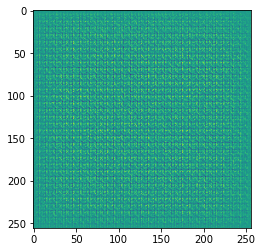

In [11]:
generator = make_generator_model()
noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

# The Discriminator

In [12]:
if advancedGan:
    def make_discriminator_model():
        inputs = layers.Input(shape=(256,256,3))
        x = layers.Conv2D(32, 4, strides=(2, 2), padding='same')(inputs)
        x = layers.LeakyReLU()(x)

        assert x.shape.as_list() == [None, 128, 128, 32]
        x = resnet_blocks_2(num_of_blocks=2, x=x, kernelsize=3, num_of_filters=32)

        x = layers.Conv2D(64, 4, strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        assert x.shape.as_list() == [None, 64, 64, 64] 

        x = resnet_blocks_2(num_of_blocks=2, x=x, kernelsize=3, num_of_filters=64)

        x = layers.Conv2D(128, 4, strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        assert x.shape.as_list() == [None, 32, 32, 128] 

        x = resnet_blocks_2(num_of_blocks=2, x=x, kernelsize=3, num_of_filters=128)

        x = layers.Conv2D(256, 4, strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        assert x.shape.as_list() == [None, 16, 16, 256] 

        x = resnet_blocks_2(num_of_blocks=2, x=x, kernelsize=3, num_of_filters=256)

        x = layers.Conv2D(512, 4, strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)

        assert x.shape.as_list() == [None, 8, 8, 512] 

        x = resnet_blocks_2(num_of_blocks=2, x=x, kernelsize=3, num_of_filters=512)

        x = layers.Conv2D(1024, 4, strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)

        assert x.shape.as_list() == [None, 4, 4, 1024] 

        outputs = layers.Flatten()(x)
        outputs = layers.Dense(1)(outputs)

        return keras.Model(inputs = inputs, outputs = outputs, name = "Discriminator_Network")

In [13]:
if not advancedGan:
    def make_discriminator_model():
        inputs = layers.Input(shape=(256,256,3))
        x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                         input_shape=[256, 256, 3])(inputs)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Flatten()(x)
        outputs = layers.Dense(1)(outputs)

        return keras.Model(inputs = inputs, outputs = outputs, name = "Discriminator_Network")

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.01005786]], shape=(1, 1), dtype=float32)


# Loss and optimizer

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator Loss

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator Loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Learning rates

In [18]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

# Save Checkpoints

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Plot Generator and Discriminator loss

In [20]:
import matplotlib.ticker as ticker

def plot_loss(gen_loss, disc_loss):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.plot(gen_loss, 'b', label="Gen loss")
    plt.plot(disc_loss, 'r', label="Disc loss")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.legend()
    plt.show()
    

# Training loop

In [21]:
EPOCHS = 50
noise_dim = 256
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [23]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  for epoch in range(epochs):
    start = time.time()
    gen_loss_sum = 0
    disc_loss_sum = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_sum += gen_loss
      disc_loss_sum += disc_loss
    
    gen_losses.append(gen_loss_sum / len(dataset))
    disc_losses.append(disc_loss_sum / len(dataset))
    
    # Reset output
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, True)
    
    plot_loss(gen_losses, disc_losses)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, True)

# Generate and save Images

In [24]:
def generate_and_save_images(model, epoch, test_input, save=False):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  gen_fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] +1) /2)
      plt.axis('off')
  if(save):
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the Model

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

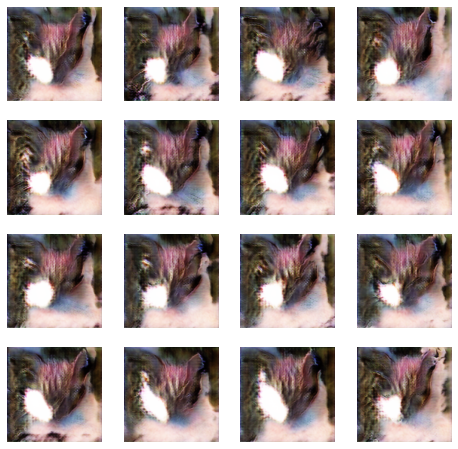

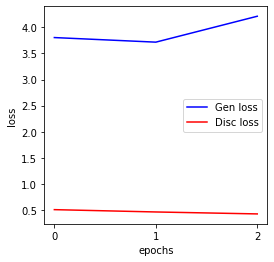

Time for epoch 3 is 165.8714554309845 sec


In [ ]:
train(train_dataset, EPOCHS)

# Restore latest checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))